In [1]:
from gammapy.estimators import TSMapEstimator
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
)

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from modules.variables import *

In [2]:
# Define the name of the dataset file
IDs = 'all_IDs'
e_min = 1
e_max = 200
bin = 20
binsz = 0.02
dataset_name = f"width_22x10/dataset_{IDs}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}.fits.gz"

In [3]:
dataset = MapDataset.read(filename= path_to_datasets / dataset_name)

In [4]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
dataset_image = dataset.to_image()

### Show skymap

White dots are the pointings of the single observations

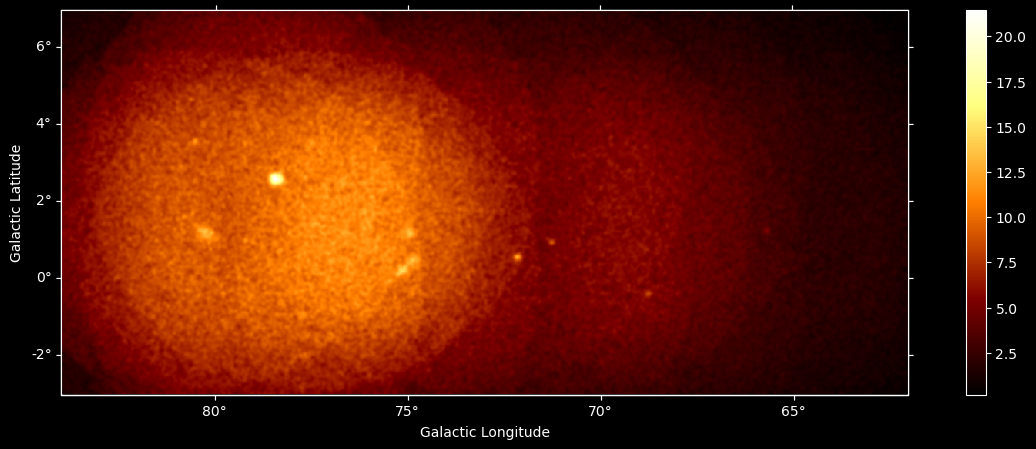

In [5]:
plt.figure(figsize=(15, 5))
ax = dataset_image.counts.smooth(2).plot(add_cbar=True)
plt.show()

### Compute TS map

In [6]:
spatial_model = PointSpatialModel()

# We choose units consistent with the map units here...
spectral_model = PowerLawSpectralModel(amplitude="1e-15 cm-2 s-1 TeV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

estimator = TSMapEstimator(
    model,
    kernel_width="0.1 deg",
    energy_edges=[0.7, 100] * u.TeV,
)
maps = estimator.run(dataset)

### Show TS map

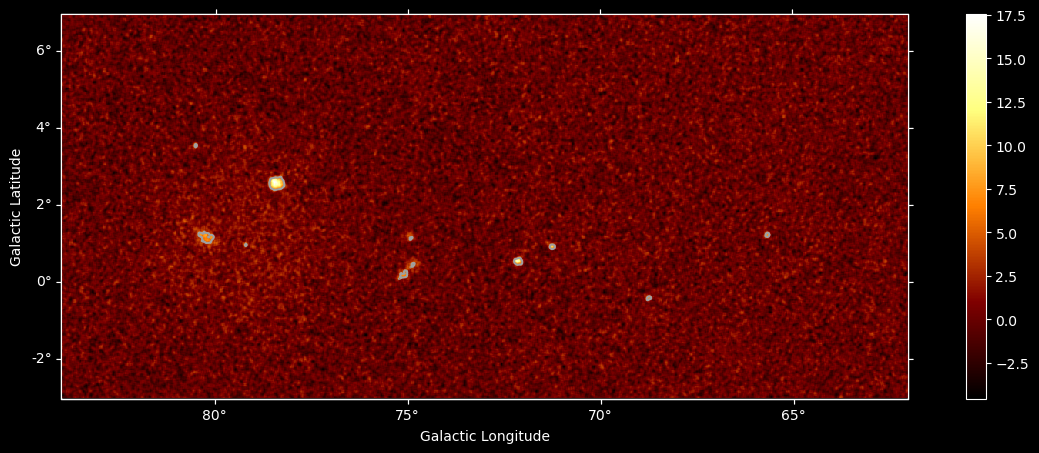

In [7]:
plt.figure(figsize=(15, 5))
maps["sqrt_ts"].plot(add_cbar=True)
cs = plt.contour(maps.sqrt_ts.data[0], levels=[5],
    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
cs.changed()
plt.show()

### Create mask regions

In [8]:
mask_map_significance = maps["sqrt_ts"] > 5.0
invalid_pixels = np.isnan(maps["sqrt_ts"].data)
mask_map_significance.data[invalid_pixels] = True

<WCSAxes: >

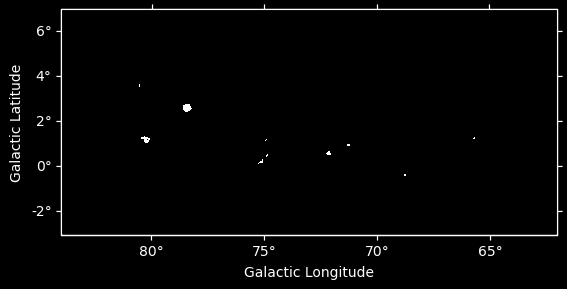

In [9]:
mask_map_significance.sum_over_axes().plot()

In [10]:
# To save masks to disk
mask_map_int = mask_map_significance.copy()
mask_map_int.data = mask_map_int.data.astype(int)
mask_map_int.write(path_to_maps / "exclusion_mask.fits", overwrite="True")